# Introduction

The Makridakis Competitions (also known as the M-Competitions) are a series of open competitions organized by teams led by forecasting researcher Spyros Makridakis and intended to evaluate and compare the accuracy of different forecasting methods - source(Wikipedia)

Attempting to to approach the forecasting with a number of models. Used Tarun's Kernel to begin with.
And it will be evolved over with my own intuitions etc. We have been challenged to forecast the data 28 days in to the future ie from day 1914 to day 1941. We would be attempting to due the forecast as well as the uncertainty distribution.

### The DataSet

* calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].

* submission.csv - Demonstrates the correct format for submission to the competition.

* sell_prices.csv - Contains information about the price of the products sold per store and date.

* sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].



Lets try to visualize the data and get some insights

Import Libraries

In [28]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm
from random import randint

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import calendar
import datetime
from matplotlib.colors import ColorConverter, ListedColormap

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy
from scipy.fftpack import fft
import statsmodels
from scipy import signal
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")


In [29]:
input_dir = '/kaggle/input/m5-forecasting-accuracy'
calender = pd.read_csv('%s/calendar.csv' % input_dir)
selling_prices = pd.read_csv('%s/sell_prices.csv' % input_dir)
sample_submission = pd.read_csv('%s/sample_submission.csv' % input_dir)
sales_train_val = pd.read_csv('%s/sales_train_validation.csv' % input_dir)

In [30]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


We can observe there is an id for each of departments, category, item and a general id which is a combination of all these. Many of the data points ahs got zero values. The sales date are denoted by 'd_'.

## Data Visualization

In [31]:
ids = np.unique(sales_train_val.id.values)
date_cols = [c for c in sales_train_val.columns if 'd_' in c]

## Understanding the sales data


By plotting the sales data for a shorter time duration, we can get a better picture or better visualization


In [32]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[12]].set_index('id')[date_cols].values[0][:120]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[date_cols].values[0][240:360]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[47]].set_index('id')[date_cols].values[0][600:720]

fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample", marker=dict(color="limegreen")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample", marker=dict(color="hotpink")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample", marker=dict(color="lightsteelblue")), row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample Sales Snippets")
fig.show()

As we can see that the since the data changes sharply between the days.  We can apply some smoothening to visualize any underlying trends. At firt lets start with some time averaging using **Savitzky golay** filters. 
By controlling the window length and polynomila order we we can get a smoothened curve from these. The window length chosen here just bu intuition, if its bigger you will get a more smoothened curve.

Also another way  we can go for is wavelet denoising

In [33]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[5]].set_index('id')[date_cols].values[0][:120]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[7]].set_index('id')[date_cols].values[0][240:360]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[13]].set_index('id')[date_cols].values[0][600:720]

smoothened_signal_1 = signal.savgol_filter(x_1, polyorder = 3, window_length=15)
smoothened_signal_2 = signal.savgol_filter(x_2, polyorder = 3, window_length=15)
smoothened_signal_3 = signal.savgol_filter(x_3, polyorder = 3, window_length=15)


fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="limegreen")), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=smoothened_signal_1, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkgreen")), row=1, col=1)



fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="hotpink")), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=smoothened_signal_2, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkred")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="original signal", marker=dict(color="lightsteelblue")), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=smoothened_signal_3, showlegend=False,
                    mode='lines', name="smoothened signal", marker=dict(color="darkslateblue")), row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample Sales Snippets")
fig.show()


### Aggregate Sales vs Time

We can start doing the same for different aggregation levels. Since we haver got three states, That can be an aggregation parameter, then storewise, department wise etc.

In [34]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())
    
date_range = calender['date']
d_st = date_range.values[0]
d_end = date_range.values[1912]
    
date_range = pd.date_range(start=d_st, end=d_end)

# Doing a monthly time averaging we can plot them along side

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
monthly_time_seies_df = daily_time_series_df.resample('1M').sum()

fig = make_subplots(rows=2, cols=1, subplot_titles=("Daily Aggregate Sales", "Monthly Aggregate Sales"))

fig.add_trace(go.Scatter(x=date_range, y=aggr_array, showlegend=False,
                    mode='lines', name="Aggregate Sales", marker=dict(color="darkgreen")), row = 1, col=1)
fig.add_trace(go.Scatter(x=monthly_time_seies_df.index[1:-1], y=monthly_time_seies_df['Sales'].values[1:-1],
                         marker=dict(color="darkgreen")), row = 2, col=1)

fig.update_layout(title="Aggregate Sales",height=1200, width=1000)
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Sales in Units", row=1, col=1)
fig.update_yaxes(title_text="Sales in Units", row=2, col=1)
fig.show()

Ahh nice! plotly is a savior!. Good thing is that you can zoom in over the graphs.

some observations we can take away
*  Sales are increasing over time
*  There are seasonal behaviors in sales trends such as monthly/weekly trends. Out of this, the weekly trends are very evident.
* End of every year there is a sharp dip in sales may be due to the vacation/holiday season.

May be we can do some time based normalisation and apply a Fourier/Wavelet transform to get more idea about the trend frequencies. But lets keep it for later(sorry, just being a fan of Fourier transforms !)

Now lets plot the sepearte data statewise

In [35]:
store_ids = sales_train_val['store_id'].values
state_id = []

for id in store_ids:
    state_id.append(id[:2])
state_id = np.array(state_id)
sales_train_val['state_id'] = state_id

df_grouped_statewise = sales_train_val.groupby('state_id')

fig = go.Figure()

for name, group in df_grouped_statewise:
    aggr_array = []
    for d in date_cols:
        aggr_array.append(group[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
    fig.add_trace(go.Scatter(x=monthly_time_seies_df.index[1:-1], y=monthly_time_seies_df['Sales'].values[1:-1],
                             showlegend=True, mode='lines', name="%s Sales" % name))
fig.update_layout(
    title="State Wise Aggregate Sales", xaxis_title="Date", yaxis_title="Unit Sales", height=600, width=1000)
fig.show()

## Plotting Aggregate Sales per Stores

There are 3 categories and 10 stores in total. We can try plotting for each of the categories and for stores in each state. Using matplotlib this time. Here I am using both plotly and Matplotlib throughout the notebook. Users can have a good feel how these libraries can be used for dynamoic plotting of data.


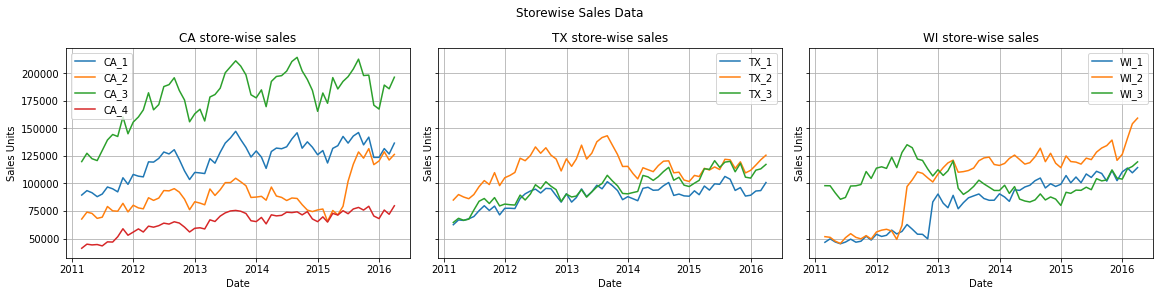

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')
i = 0
for state_name, state_group in df_grouped_statewise:
    df_store_wise_grouped = state_group.groupby('store_id')
    axs[i].set_title('%s store-wise sales' % state_name)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    axs[i].grid(True)
    for store_name, store_group in df_store_wise_grouped:
        aggr_array = []
        for d in date_cols:
            aggr_array.append(store_group[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
        axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1], label='%s' % store_name)
        axs[i].legend()
    i += 1

plt.show()

Quick Observation:
    
The sales in stores in California varies by a lot. It could be due local tech Industry booms, leading to higher purchasing power/higher migrant population etc.

Sales in Texas stores are fairly Equally placed. We can see a general dip in sales around 2014. That could be due to Oil price collapse during 2014. Since Texas is highly dependant on oil revenue, that could have dragged local income and hence their purchasing power as well

Thw WI_1 & WI_2 stores shows a surprising jump towards the beginning of 2013. This could be due to say opening up of a major Industrial facility providing lots of jobs simulataneously(By the way these are just guesses!)


## Sales per Category/Department

For time being lets plot only for CA stores

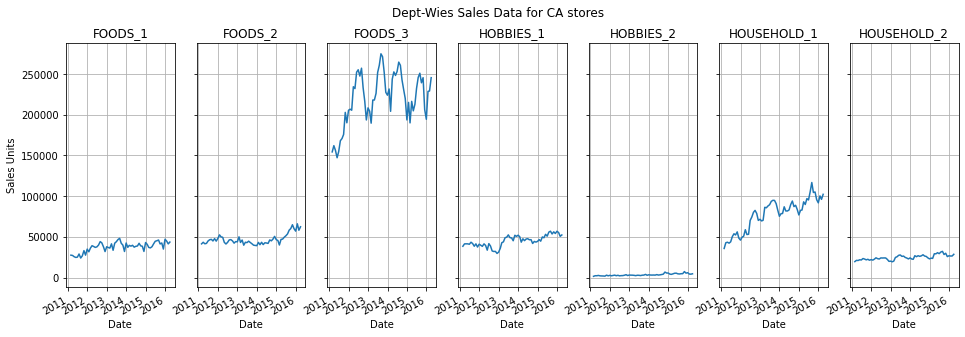

In [37]:
ca_stores_df = df_grouped_statewise.get_group('CA')

departments = np.unique(ca_stores_df['dept_id'].values)

fig, axs = plt.subplots(1, len(departments), figsize=(16, 5), sharey=True)
fig.suptitle('Dept-Wies Sales Data for CA stores')

for i, d in enumerate(departments):
    axs[i].set_title('%s' % d)
    axs[i].set(xlabel='Date')
    if i == 0:
        axs[i].set(ylabel='Sales Units')
    axs[i].grid(True)
    dept_sales_data = ca_stores_df[ca_stores_df['dept_id'] == d]
    aggr_array = []
    for d in date_cols:
        aggr_array.append(dept_sales_data[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
    axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1],
                label='%s' % store_name)
fig.autofmt_xdate()
fig.show()

## Decompose Time Series Data into Trend and Seasonality
Got these excellent explations from the website:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting

Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.
**Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

**Level**: The average value in the series.

**Trend**: The increasing or decreasing value in the series.

**Seasonality**: The repeating short-term cycle in the series.

**Noise**: The random variation in the series.

**Additive Model**
An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise
An additive model is linear where changes over time are consistently made by the same amount.

**Multiplicative Model**
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level x Trend x  Seasonality x  Noise

As a first step we can analyse the series assuming it as a Additive data.
Here I am trying with naive decomposition to begin with.

In [38]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)


series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='additive')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()



## Observations
Clearly we can see the different components at play. At this moment we can not be so sure if this is the exact decomposition we want. But honestly it looks nice to me!
I has clearly captured the weekly seasonalities, The Monthly seasonality where the sales peaks shortly after the pay date(assuming monthly pay).
Lets have a closer look at the Sesonal component, before even having a look I would guess its the weekly variations captured in there. But anyways lets have a look!

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_range[:140], y=result_list[1][:140], showlegend=True, mode='lines'))
fig.update_layout(title="Seasonal Component", xaxis_title="Date", yaxis_title="Units/Value", height=500, width=800)
fig.show()

### Observations continued
Okay if we can have an even closer look, its clear that it shows the weekly fluctuations in the sales data where the sales peaks at weekends(Saturday and Sunday).

Moving to the noise component(noise), The dip at year end is captured there rather being in seasonal trend. But its okay we know whats going on right.

It would be a good comparison between the Trend part of of the decomposition and the overall trend for Observed data. It can bring in an idea how effective our decomposition algorithm is here.Lets bring in polynomial regressor do make a trendline

In [40]:
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_train_val[d].values.sum())

daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)

X_values = range(len(daily_time_series_df))
coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend'] = y_hat

# since there are some nan values at the beginning and end lets take those values out.
decomp_trend = result.trend[3:-3]
coeffs = np.polyfit(X_values[3:-3], decomp_trend, 5)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(X_values)

daily_time_series_df['sales_trend_decomp'] = y_hat

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['Sales'].values,
                             showlegend=True, mode='lines'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend'].values, mode='lines',
                        showlegend=True, marker=dict(color="black"), name='observed_trend'))
fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend_decomp'].values, mode='lines',
                        showlegend=True, marker=dict(color="orange"), name = 'decomposed trend'))
fig.update_layout(
    title="Observed Sales and trend-line", xaxis_title="Date", yaxis_title="Unit Sales", height=500, width=1000)
fig.show()

Its clear from the plots that, the trendline from seasonal decomposition is quite aligned with the observed trendline. Hence the naive decomposition does a very good job in getting here the trend right.

Another thing we can perform is doing a multiplicative decomposition and analyse the results. But its usually meant for non-linear scenario. But well, there isn't any harm in giving a try right!

## Multiplicative Decomposition


In [41]:
series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='multiplicative')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()

### Observations
like the additive decomposition, the multiplicative decomposition also churns out similar data set. So here the linearity/non-linearity ddnt matter at all!. The sesonal component clearly identifies what to be multiplied with the data.

Now lets attempt to plot the data Statewise and further we can dig in storewise as well.

In [42]:
state_ids = np.unique(sales_train_val['state_id'].values)
fig = make_subplots(rows=1, cols=3, subplot_titles = state_ids)

for i, st_id in enumerate(state_ids):
    state_wise_df = sales_train_val[sales_train_val['state_id'] == st_id]

    aggr_array = []
    for d in date_cols:
        aggr_array.append(state_wise_df[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    
    X_values = range(len(daily_time_series_df))
    coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
    poly_eqn = np.poly1d(coeffs)
    y_hat = poly_eqn(X_values)

    daily_time_series_df['sales_trend'] = y_hat
    
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['Sales'].values,
                             showlegend=True, mode='lines', name="%s Sales" % name), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=daily_time_series_df['sales_trend'].values,
                             showlegend=True,marker=dict(color="black"), mode='lines', name="%s Sales" % name), row=1, col=i + 1)
fig.update_layout(
    title="State Wise Aggregate Sales & Trend", xaxis_title="Date", yaxis_title="Unit Sales", height=400, width=1100)
fig.show()

We can observe similar trends statewise as well in the above graph. Let's go another level deep, Say plotting it Departmentwise. I think It would better if can plot the the trend values along with the daily fluctuating values to get a good feel.

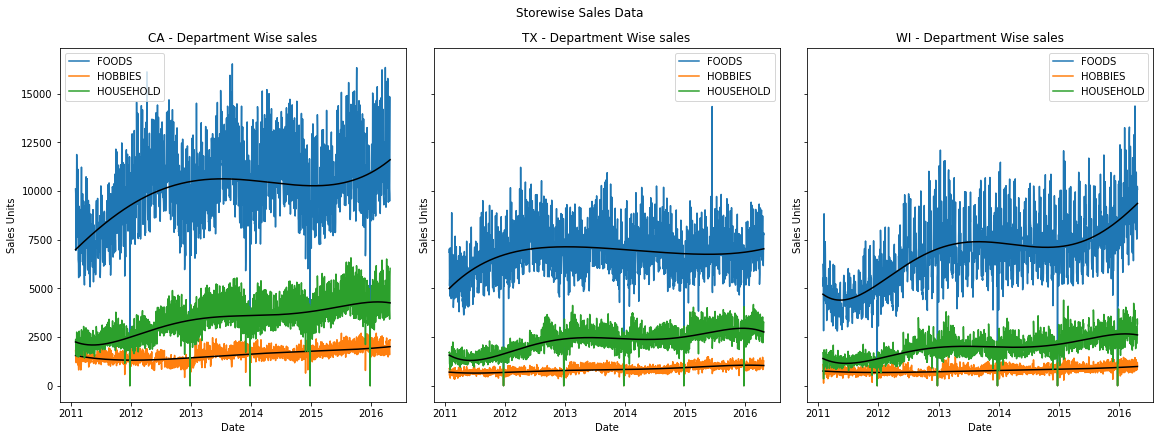

In [43]:
dept_ids = sales_train_val['dept_id'].values
dept_category = []
for d_id in dept_ids:
    dept_category.append(d_id[:-2])
dept_category = np.array(dept_category)

sales_train_val['dept_cat'] = dept_category
dept_cat_ids = np.unique(dept_category)

# using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')

for i, st_id in enumerate(state_ids):
    state_wise_df = sales_train_val[sales_train_val['state_id'] == st_id]
    axs[i].set_title('%s - Department Wise sales' % st_id)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    for j, dp_cat_id in enumerate(dept_cat_ids):
        dept_wise_df = state_wise_df[state_wise_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        
        X_values = range(len(daily_time_series_df))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat = poly_eqn(X_values)

        daily_time_series_df['sales_trend'] = y_hat
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['Sales'].values, label='%s' % dp_cat_id)
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['sales_trend'].values, color = 'black')
        axs[i].legend()
plt.show()

Okay! So food is the wild card here with maximum fluctuations fluctuations observed. We can go on an on ploting subcategories etc. But may be keep it for a while later.
I think its also important to capture the weekly and monthly seasonality of Sales. So lets try plotting that.


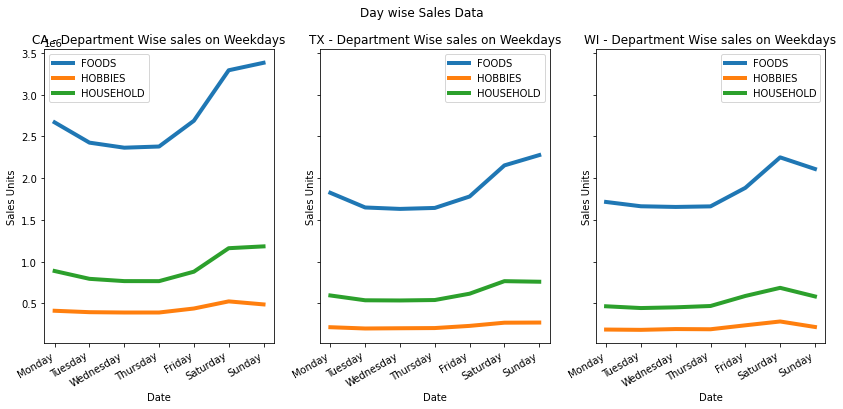

In [44]:
fig, axs = plt.subplots(1, len(state_ids), figsize=(14, 6), sharey=True, constrained_layout=True)
fig.suptitle('Day wise Sales Data')
weekdays = calender['weekday'][:1913]
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, st_id in enumerate(state_ids):
    state_wise_df = sales_train_val[sales_train_val['state_id'] == st_id]
    for dp_cat_id in dept_cat_ids:
        dept_wise_df = state_wise_df[state_wise_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        daily_time_series_df['weekday'] = weekdays.values
        weekly_data = []
        for w in weekday_names:
            day_wise_sum = (daily_time_series_df[daily_time_series_df['weekday'] == w])['Sales'].values.sum()
            weekly_data.append(day_wise_sum)

        axs[i].plot(weekday_names, weekly_data, label='%s' % dp_cat_id, linewidth=4)
        axs[i].legend()
    axs[i].set_title('%s - Department Wise sales on Weekdays' % st_id)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
fig.autofmt_xdate(rotation=30)
plt.show()

Okay, we can clearly observe the the sales rises in the weekend and Its even high on Monday. Trend for Hobbies category is not that visible with the above scale, but I am expecting a similar behaviour for the same.


## Calender data

Lets look at the events going on after this from the calendar data. The are specific days at which events are going on, which could boost or affect the sales. We dont know! lets have a look

In [45]:
print(np.unique(calender.event_name_1.astype(str), return_counts=True))
print(np.unique(calender.event_type_1.astype(str), return_counts=True))
print(np.unique(calender.event_name_2.astype(str), return_counts=True))
print(np.unique(calender.event_type_2.astype(str), return_counts=True))

(array(['Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay',
       'Easter', 'Eid al-Fitr', 'EidAlAdha', "Father's day", 'Halloween',
       'IndependenceDay', 'LaborDay', 'LentStart', 'LentWeek2',
       'MartinLutherKingDay', 'MemorialDay', "Mother's day",
       'NBAFinalsEnd', 'NBAFinalsStart', 'NewYear', 'OrthodoxChristmas',
       'OrthodoxEaster', 'Pesach End', 'PresidentsDay', 'Purim End',
       'Ramadan starts', 'StPatricksDay', 'SuperBowl', 'Thanksgiving',
       'ValentinesDay', 'VeteransDay', 'nan'], dtype=object), array([   5,    5,    5,    5,    5,    5,    5,    4,    5,    5,    5,
          6,    6,    5,    6,    6,    6,    6,    5,    5,    5,    6,
          6,    6,    6,    6,    6,    5,    6,    5, 1807]))
(array(['Cultural', 'National', 'Religious', 'Sporting', 'nan'],
      dtype=object), array([  37,   52,   55,   18, 1807]))
(array(['Cinco De Mayo', 'Easter', "Father's day", 'OrthodoxEaster', 'nan'],
      dtype=object), array([   1,    1,    2, 

Okay this gives a quick numerical look @ the data. And another inpection , looking in to the parameters event_name_2 and event_type_2, they are only a few and most likely a spinoff from the first set. I am ignoring those. 

Lets plot in year wise how many days we have got events happening, type of event etc.

Since I couldn't install the package, I just copied the revelant fuction to plot the calendar events.
If anyone knows letme know how to permenantly install a new package in kaggle!. otherwise I face quite a bit of trouble installing it everytime

In [46]:

 
def yearplot(data, year=None, how='sum', vmin=None, vmax=None, cmap='Reds',
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,
             **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
 
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
 
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    """
    if year is None:
        year = data.index.sort_values()[0].year
 
    if how is None:
        
        by_day = data
    else:
        
        by_day = data.resample('D', how=how)
 
    # Min and max per day.
    if vmin is None:
        vmin = by_day.min()
    if vmax is None:
        vmax = by_day.max()
 
    if ax is None:
        ax = plt.gca()
 
    if linecolor is None:
        linecolor = ax.get_facecolor()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'
 
    # Filter on year.
    by_day = by_day[str(year)]
 
    # Add missing days.
    by_day = by_day.reindex(
        pd.date_range(start=str(year), end=str(year + 1), freq='D')[:-1])
 
    # Create data frame we can pivot later.
    by_day = pd.DataFrame({'data': by_day,
                           'fill': 1,
                           'day': by_day.index.dayofweek,
                           'week': by_day.index.week})
 
    # There may be some days assigned to previous year's last week or
    # next year's first week. We create new week numbers for them so
    # the ordering stays intact and week/day pairs unique.
    by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), 'week'] = 0
    by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), 'week'] \
        = by_day.week.max() + 1
 
    # Pivot data on day and week and mask NaN days.
    plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
 
    # Do the same for all days of the year, not just those we have data for.
    fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
    fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)
 
    # Draw heatmap for all days of the year with fill color.
    ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))
 
    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
 
    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))
 
    # Square cells.
    ax.set_aspect('equal')
 
    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)
 
    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2::monthticks]
 
    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []
    elif isinstance(dayticks, int):
        dayticks = range(len(daylabels))[dayticks // 2::dayticks]
 
    ax.set_xlabel('')
    ax.set_xticks([by_day.ix[datetime.date(year, i + 1, 15)].week
                   for i in monthticks])
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center')
 
    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([6 - i + 0.5 for i in dayticks])
    ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal',
                       va='center')
    return ax


Below we use the information from the calender file plot days with events alongside days of the year. He I have just shown it for the days in 2012.

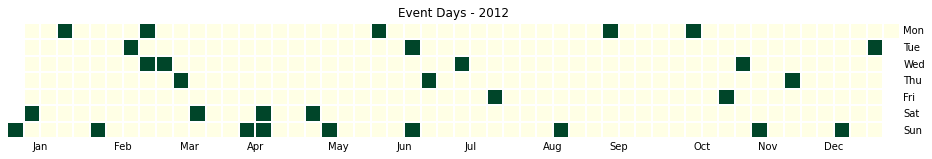

In [47]:
boolean_event_index = calender['event_name_1'].notnull()[:len(date_range)].values
event_days = pd.Series(np.ones(len(date_range)) * boolean_event_index, index=date_range)

fig, axs = plt.subplots(1, 1, figsize=(16, 4))
axs = yearplot(event_days, year=2012, cmap="YlGn")
axs.set_title('Event Days - 2012')
fig.show()

## SNAP - Supplemental Nutrition Assistance Program (SNAP)
The info is obtained from their website:

SNAP provides nutrition benefits to supplement the food budget of needy families so they can purchase healthy food and move towards self-sufficiency.
SNAP can only buy food for the household, so any analysis for this set of data should be attributed to food in general.


Another interesting analysis I can think about is to predict the effect of events on sales volumes. We might have to do it quite carefully of course, after seggregated by state and department-wise.
I would prefer to compare it with the trend data we isolated and see how much difference it makes with the day before that or after.
Also it would be good check if we can kind-of find an overlapping tendency between the noise and holidays as well. Here we also make some assumptions that
1. weekly fluctuations are taken care by the seasonal behavior
2. Trend is a good enough metric to compare 

Lets begin!
Like as I mentioned before analysing the data by statewise/dept wise makes more sense than putting it all together. Lets start with the Texan stores.

### Days with SNAP purchase

A similar calender plot can be made for SNAP days, by that way we can get the effect of the same on purchases of food items(most likely)

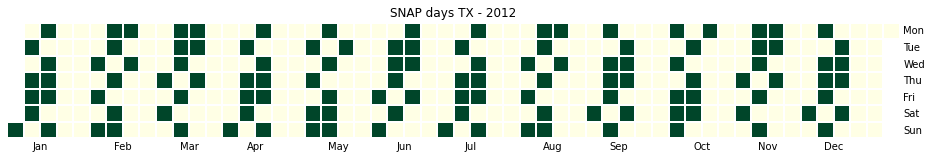

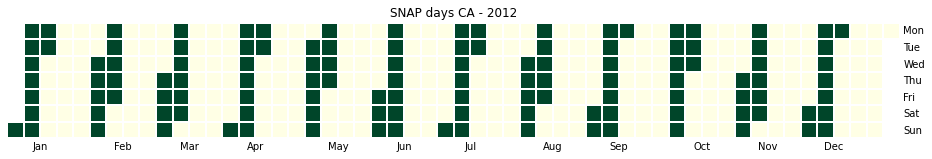

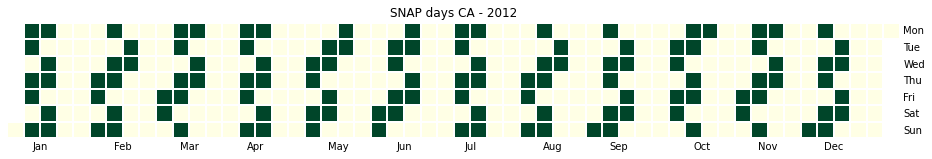

In [48]:
# plotting SNAP days
snap_tx = pd.Series(calender.snap_TX[:len(date_range)].values, index=date_range)
snap_ca = pd.Series(calender.snap_CA[:len(date_range)].values, index=date_range)
snap_wi = pd.Series(calender.snap_WI[:len(date_range)].values, index=date_range)

fig1, axs1 = plt.subplots(1, 1, figsize=(16, 12))
axs1 = yearplot(snap_tx, year=2012, cmap="YlGn")
axs1.set_title('SNAP days TX - 2012')
fig1.show()

fig2, axs2 = plt.subplots(1, 1, figsize=(16, 12))
axs2 = yearplot(snap_ca, year=2012, cmap="YlGn")
axs2.set_title('SNAP days CA - 2012')
fig2.show()

fig3, axs3 = plt.subplots(1, 1, figsize=(16, 12))
axs3 = yearplot(snap_wi, year=2012, cmap="YlGn")
axs3.set_title('SNAP days CA - 2012')
fig3.show()

In [49]:
texas_df = sales_train_val[sales_train_val['state_id'] == 'TX']
fig = make_subplots(rows=4, cols=3, subplot_titles = dept_cat_ids)
for i, dp_cat_id in enumerate(dept_cat_ids):
    dept_wise_df = texas_df[texas_df['dept_cat'] == dp_cat_id]
    aggr_array = []
    for d in date_cols:
        aggr_array.append(dept_wise_df[d].values.sum())
    daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
    series = daily_time_series_df['Sales']
    result = seasonal_decompose(series, model='additive')
    result_list = [result.trend, result.seasonal, result.resid, result.observed]
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=result.trend,
                             showlegend=True, mode='lines', name="%s Trend" % dp_cat_id), row=1, col=i + 1)
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=result.seasonal,
                             showlegend=True, mode='lines', name="%s Seas" % dp_cat_id), row=2, col=i + 1)
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=result.resid,
                             showlegend=True, mode='lines', name="%s Resid" % dp_cat_id), row=3, col=i + 1)
    fig.add_trace(go.Scatter(x=daily_time_series_df.index, y=result.observed,
                             showlegend=True, mode='lines', name="%s Obser" % dp_cat_id), row=4, col=i + 1)
    
fig.update_layout(title="TX Seasonal Department-wise Decomposition", height=800, width=1200)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Sales Units", row=1, col=1)
fig.update_yaxes(title_text="Sales Units", row=2, col=1)
fig.update_yaxes(title_text="Sales Units", row=3, col=1)
fig.update_yaxes(title_text="Sales Units", row=4, col=1)                
fig.show()

From the obove visualisations we can get a clear idea regarding the seasonal effects involved in each of the categories.

The next task would be to analyse and quanity the effect of Event days and SNAP days. That can be tried out may be getting the trend lines for SNAP days and Event days seperate. I am not sure at this moment at what exact level of details we need comparison, but lets start with the effect on foods category.

lets plot and compare the trend lines for TX for event and snap days seperately

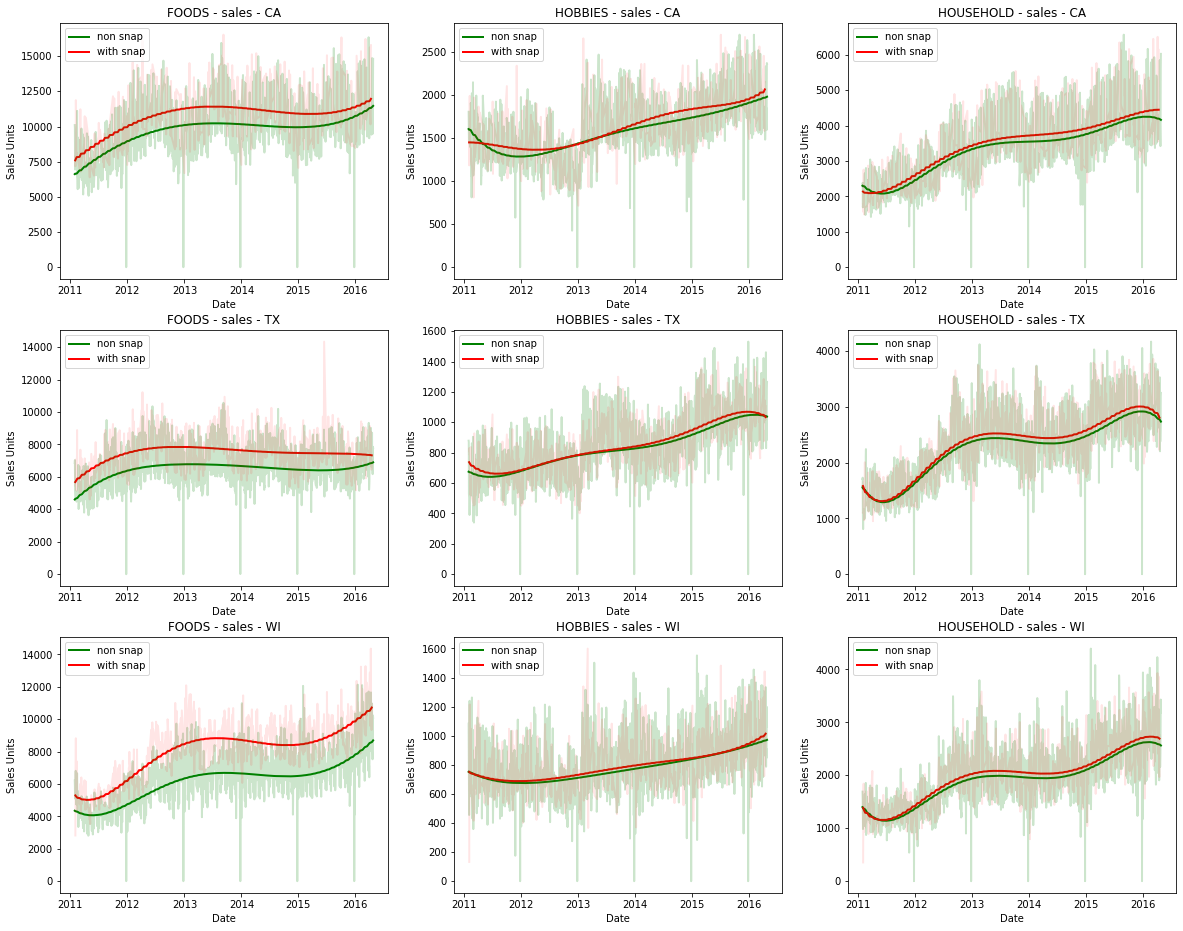

In [50]:

fig, axs = plt.subplots(3, 3, figsize=(20, 16))

for j, st_id in enumerate(state_ids):
    snap_state_id = 'snap_%s' % st_id
    snap_state = pd.Series(calender[snap_state_id][:len(date_range)].values, index=date_range)
    snap_state_df = snap_state.reset_index()
    snap_on_state_df = snap_state_df[snap_state_df[0] == 1]
    snap_off_state_df = snap_state_df[snap_state_df[0] == 0]
    
    state_df = sales_train_val[sales_train_val['state_id'] == st_id]
    for i, dp_cat_id in enumerate(dept_cat_ids):
        dept_wise_df = state_df[state_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        series = daily_time_series_df['Sales']

        X_values = range(len(snap_off_state_df.index.values))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values[snap_off_state_df.index.values], 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat_snap_off = poly_eqn(X_values)

        X_values = range(len(snap_on_state_df.index.values))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values[snap_on_state_df.index.values], 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat_snap_on = poly_eqn(X_values)

        axs[j, i].plot(snap_off_state_df['index'], y_hat_snap_off, label= 'non snap', linewidth=2, color = 'green')
        axs[j, i].plot(snap_on_state_df['index'], y_hat_snap_on, label= 'with snap', linewidth=2, color = 'red')
        axs[j, i].plot(snap_off_state_df['index'], daily_time_series_df['Sales'].values[snap_off_state_df.index.values],
                    linewidth=2, color = 'green', alpha = 0.2)
        axs[j, i].plot(snap_on_state_df['index'], daily_time_series_df['Sales'].values[snap_on_state_df.index.values],
                    linewidth=2, color = 'red', alpha = 0.1)
        axs[j, i].legend()
        axs[j, i].set_title('%s - sales - %s' % (dp_cat_id, st_id))
        axs[j, i].set(xlabel='Date', ylabel='Sales Units')
plt.show()

Okay, great!. Things are getting more clear. Food sales are considerably higher in all the states compared to other categories.. There is also a marginal effect on the other items as well. These are all useful inputs which can go in to forecasting. But there is also an evident trend seen in Texas, that SNAP effect is thinning out toward the end, whereas for Wisconsin its still prominent towards 2016 may be at around the same level.

The next one may be we can think about trying out is with respect to days with events. But since they are considerably sparse, the analysis accuracy could be considerably lower. But there is no harm in trying it out right.

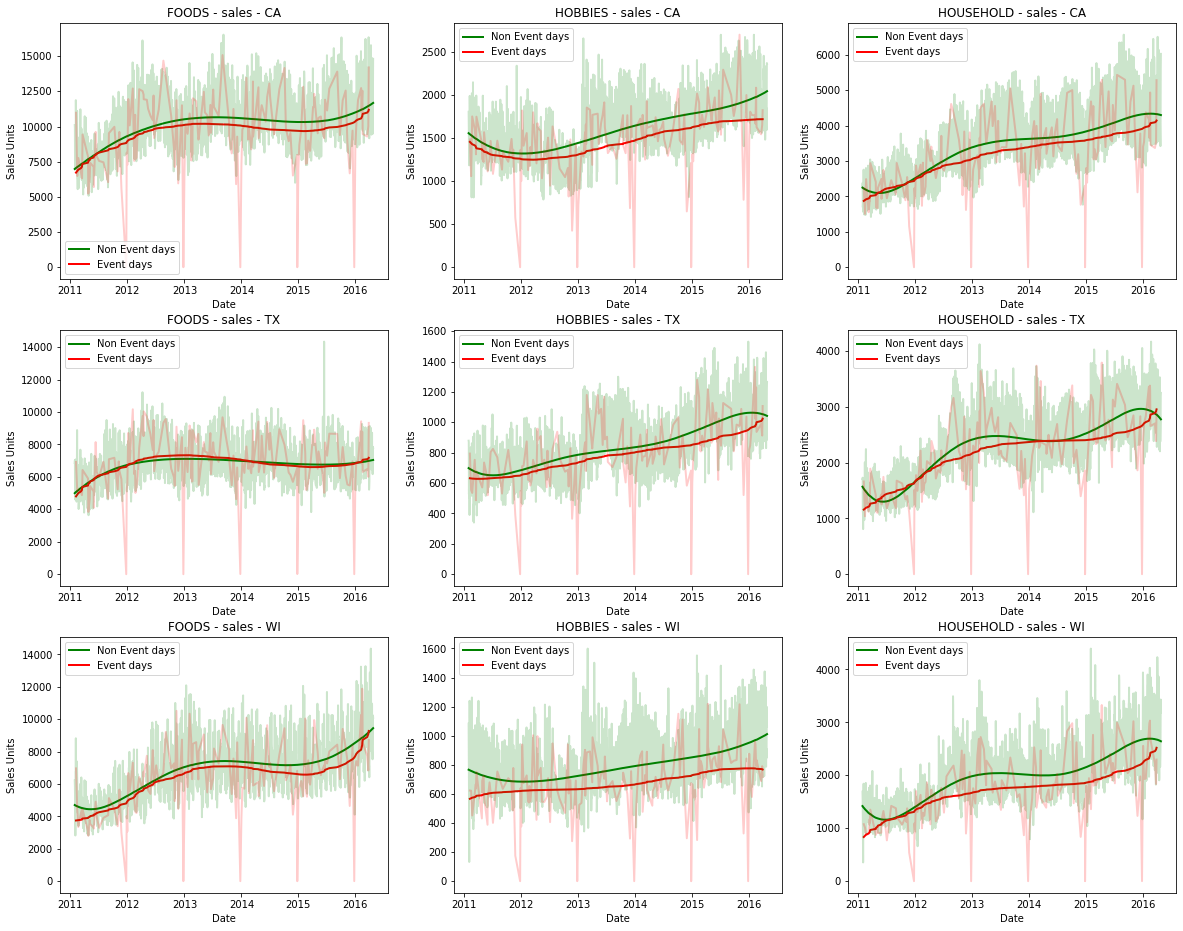

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(20, 16))

boolean_event_index = calender['event_name_1'].notnull()[:len(date_range)].values
event_days = pd.Series(np.ones(len(date_range)) * boolean_event_index, index=date_range)
event_days_df = event_days.reset_index()
event_on_df = event_days_df[event_days_df[0] == 1]
event_off_df = event_days_df[event_days_df[0] == 0]

for j, st_id in enumerate(state_ids):
    state_df = sales_train_val[sales_train_val['state_id'] == st_id]
    for i, dp_cat_id in enumerate(dept_cat_ids):
        dept_wise_df = state_df[state_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        series = daily_time_series_df['Sales']

        X_values = range(len(event_off_df.index.values))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values[event_off_df.index.values], 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat_snap_off = poly_eqn(X_values)

        X_values = range(len(event_on_df.index.values))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values[event_on_df.index.values], 4)
        poly_eqn = np.poly1d(coeffs)
        y_hat_snap_on = poly_eqn(X_values)

        axs[j, i].plot(event_off_df['index'], y_hat_snap_off, label= 'Non Event days', linewidth=2, color = 'green')
        axs[j, i].plot(event_on_df['index'], y_hat_snap_on, label= 'Event days', linewidth=2, color = 'red')
        axs[j, i].plot(event_off_df['index'], daily_time_series_df['Sales'].values[event_off_df.index.values],
                    linewidth=2, color = 'green', alpha = 0.2)
        axs[j, i].plot(event_on_df['index'], daily_time_series_df['Sales'].values[event_on_df.index.values],
                    linewidth=2, color = 'red', alpha = 0.2)
        axs[j, i].legend()
        axs[j, i].set_title('%s - sales - %s' % (dp_cat_id, st_id))
        axs[j, i].set(xlabel='Date', ylabel='Sales Units')
plt.show()

Okay, We can derive a general conclusion out of this like the sales are usually lower in Events day, since people would like to be at home rather than going to a super market on those days. But there is one clear observation that, at the year end there is a dip, which could be attributed to christmas. Hence it would be meaningfull to have another plot to compare without the specific dip observed every year.

## Prices of Items

We have got the prices of every items and can analyse the effects of those on the demand. One analysis that we could do is how the prices varies over time. We can estimate this may be departmentwise or even one or tow random samples to start with. I think this could be reflecting on the slight inflationary trend.

Lets randomly select some of the items from the list and plot over time

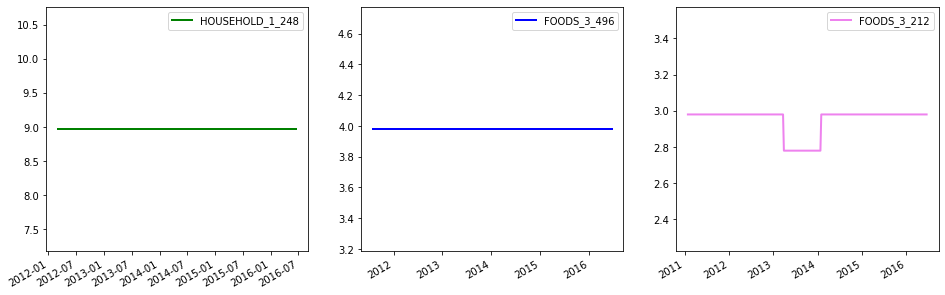

In [65]:
items = np.unique(selling_prices.item_id.values)

date_id_df = calender.iloc[:, :2].drop_duplicates(subset='wm_yr_wk', keep='first')
sp_new_df = pd.merge(selling_prices, date_id_df, on='wm_yr_wk')

# randomly choosing some products out of the list

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
color = ['green', 'blue', 'violet']
for i in range(3):
    id_ = randint(0, len(items))
    item_price_df = sp_new_df[sp_new_df.item_id == items[id_]]
    item_price_df = item_price_df[item_price_df.store_id == 'CA_1']
    item_price_df['date'] = pd.to_datetime(item_price_df.date)
    item_price_df = item_price_df.sort_values(by='date')
    ymin = (item_price_df.sell_price.values.min())/1.25
    ymax = (item_price_df.sell_price.values.max())*1.2
    axs[i].plot(item_price_df.date, item_price_df.sell_price, label= '%s' % items[id_], linewidth=2, color = color[i])
    axs[i].set_ylim([ymin,ymax])
    axs[i].legend()
fig.autofmt_xdate(rotation=30)
plt.show()




To be continued....

Alright, one thing is clear. There isn't any notable increase in prices over the time. Its practically constant. At this moment may be we should rule out any possibility that future prices can impact the consumption behaviour.

At last I think its time we roll in to the forecasting side....hang tight!


In [54]:
pd.to_datetime(item_price_df.date.values[0])

Timestamp('2013-07-13 00:00:00')